[View in Colaboratory](https://colab.research.google.com/github/nishasinhmar/Neural-StyleTransfer/blob/master/Neural_Style_Transfer.ipynb)

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!pip install keras

In [0]:
from __future__ import print_function
import numpy as np
from PIL import Image

import cv2

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
# Using TensorFlow backend.

In [0]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [30]:
os.getcwd()

'/content/drive/Colab_Notebooks'

In [33]:
content_image = cv2.imread("content1.jpg")
print(content_image.shape)
content_image = cv2.resize(content_image, (256, 256))
print(content_image.shape)

(646, 642, 3)
(256, 256, 3)


In [34]:
style_image = cv2.imread("style.png")
print(style_image.shape)
style_image = cv2.resize(style_image, (256, 256))
print(style_image.shape)

(270, 340, 3)
(256, 256, 3)


In [0]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
# content_array=np.array(content_array).copy()

In [36]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
# backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


In [0]:
content_array[:, :, :, 0] -= 103.939 # np.mean(content_array[:, :, :, 0])
content_array[:, :, :, 1] -= 116.779 # np.mean(content_array[:, :, :, 1])
content_array[:, :, :, 2] -= 123.68 # np.mean(content_array[:, :, :, 2])
content_array=content_array[:, :, :, ::-1]

In [0]:
# !ls

In [0]:
# import os
# os.chdir("drive/Google_Colab")

In [40]:
style_array[:, :, :, 0] -= 103.939 # np.mean(style_array[:, :, :, 0])
style_array[:, :, :, 1] -= 116.779 # np.mean(style_array[:, :, :, 1])
style_array[:, :, :, 2] -= 123.68 # np.mean(style_array[:, :, :, 2])
style_array=style_array[:, :, :, ::-1]
style_array.shape, content_array.shape

((1, 256, 256, 3), (1, 256, 256, 3))

In [41]:
np.mean(content_array[:, :, :, 0]), np.mean(content_array[:, :, :, 1]), np.mean(content_array[:, :, :, 2])

(47.44997, 21.828117, 34.161053)

In [0]:

height=256
width=256
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

In [0]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [44]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 4s 0us/step


In [0]:

content_weight = 0.5
style_weight = 3.0
total_variation_weight = 1.0

In [0]:
layers=dict([(layer.name, layer.output) for layer in model.layers])

In [0]:
loss=backend.variable(0.)

In [0]:

def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [0]:
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

In [0]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [0]:

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [0]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [0]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [0]:


def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator=Evaluator()

In [0]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 5

In [80]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
114146670000.0
Iteration 0 completed in 5s
Start of iteration 1
73405400000.0
Iteration 1 completed in 4s
Start of iteration 2
64277740000.0
Iteration 2 completed in 4s
Start of iteration 3
61185080000.0
Iteration 3 completed in 4s
Start of iteration 4
59963396000.0
Iteration 4 completed in 4s


In [0]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 123.939 # np.mean(x[:, :, 0])
x[:, :, 1] += 116.779 # np.mean(x[:, :, 1])
x[:, :, 2] += 123.68 # np.mean(x[:, :, 2])
x = np.clip(x, 0, 255).astype('uint8')

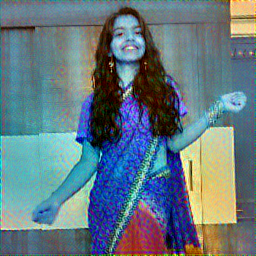

In [82]:
Image.fromarray(x)